In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

In [2]:
tf.keras.mixed_precision.set_global_policy('float32')
print(f"Using mixed precision: {tf.keras.mixed_precision.global_policy()}")

Using mixed precision: <Policy "float32">


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16555321268877483770
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10057940992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13917040360392218782
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Check if TensorFlow can access the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU available.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
base_dir = r"C:\Users\Coli\Documents\Archive\archive"

In [6]:
styles = os.listdir(base_dir)
print(styles) # Print the list of styles to verify

['Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [7]:
image_height = 224
image_width = 224
batch_size = 64
seed = 42 # For reproducibility

In [8]:
print("Loading training data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='categorical', # Your labels are one-hot encoded
    image_size=(image_height, image_width),
    interpolation='bicubic', # or 'bilinear', 'nearest'
    batch_size=batch_size,
    shuffle=True, # Shuffle training data
    seed=seed,
    validation_split=0.3, # 30% for validation/test combined
    subset='training'
)

print("Loading validation data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    interpolation='bicubic',
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    seed=seed,
    validation_split=0.3,
    subset='validation'
)

Loading training data...
Found 81410 files belonging to 16 classes.
Using 56987 files for training.
Loading validation data...
Found 81410 files belonging to 16 classes.
Using 24423 files for validation.


In [9]:
print(f"Detected class names: {train_ds.class_names}")


Detected class names: ['Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [10]:
all_image_paths = []
all_labels = []

In [11]:
grouped_styles = [
    'Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 
    'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 
    'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e'
]

In [12]:
for i, style_name in enumerate(grouped_styles):
    style_dir = os.path.join(base_dir, style_name)
    if not os.path.exists(style_dir):
        print(f"Warning: Directory for grouped style '{style_name}' not found at {style_dir}")
        continue
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        all_image_paths.append(image_path)
        all_labels.append(i)

In [13]:
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

# Perform stratified split
X_train_paths, X_temp_paths, y_train_labels, y_temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, random_state=seed, stratify=all_labels
)
X_val_paths, X_test_paths, y_val_labels, y_test_labels = train_test_split(
    X_temp_paths, y_temp_labels, test_size=0.5, random_state=seed, stratify=y_temp_labels
)


# # First, split into 70% training and 30% temporary (for validation and test)
# X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

# # Now, split the 30% temporary into 15% validation and 15% test
# # Since X_temp is 30% of the original data, 0.5 of X_temp will be 15% of the original data
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [14]:
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # Changed from "horizontal_and_vertical"
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomContrast(0.2)
], name='data_augmentation')

In [15]:
# print(f"Training set: {len(X_train)} samples ({len(X_train)/len(images)*100:.1f}%)")
# print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(images)*100:.1f}%)")
# print(f"Test set: {len(X_test)} samples ({len(X_test)/len(images)*100:.1f}%)")

def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # or decode_png
    img = tf.image.resize(img, [image_height, image_width])
    img = tf.cast(img, tf.float32) / 255.0 # Normalize
    num_classes = len(grouped_styles) # Use the count of your grouped styles
    label = tf.one_hot(label, num_classes) # One-hot encode labels
    return img, label

In [16]:
# y_train_np = np.array(y_train)
# unique_elements, counts = np.unique(y_train_np, return_counts=True)
# print("Counts of each style in y_train:")
# for element, count in zip(unique_elements, counts):
#     print(f"{element}: {count}")

# y_val_np = np.array(y_val)
# unique_elements, counts = np.unique(y_val_np, return_counts=True)
# print("Counts of each style in y_val:")
# for element, count in zip(unique_elements, counts):
#     print(f"{element}: {count}")

train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [17]:
# Check number of rows per class per dataset
print(f"Number of training samples: {len(X_train_paths)}")
print(f"Number of validation samples: {len(X_val_paths)}")
print(f"Number of test samples: {len(X_test_paths)}")

Number of training samples: 56987
Number of validation samples: 12211
Number of test samples: 12212


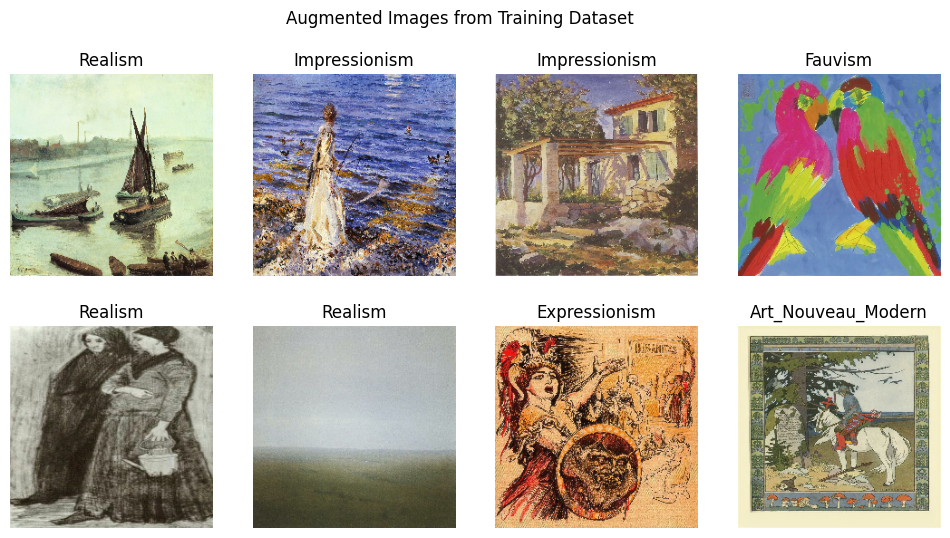

In [18]:
# Display a batch of augmented images from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(min(8, images.shape[0])):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy())
        label_idx = np.argmax(labels[i].numpy())
        plt.title(f"{grouped_styles[label_idx]}")
        plt.axis("off")
    plt.suptitle("Augmented Images from Training Dataset")
    plt.show()

In [19]:
from sklearn.utils import class_weight # For calculating class weights

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights calculated:")
for i, weight in class_weights_dict.items():
    print(f"  Class {grouped_styles[i]} (Index {i}): Weight {weight:.4f}")

Class weights calculated:
  Class Art_Nouveau_Modern (Index 0): Weight 1.1739
  Class Baroque (Index 1): Weight 1.2000
  Class Color_Field_Painting (Index 2): Weight 3.1519
  Class Cubism (Index 3): Weight 1.9864
  Class Expressionism (Index 4): Weight 0.5302
  Class Fauvism (Index 5): Weight 5.4460
  Class Impressionism (Index 6): Weight 0.2543
  Class Minimalism (Index 7): Weight 3.8052
  Class Naive_Art_Primitivism (Index 8): Weight 2.1163
  Class Pop_Art (Index 9): Weight 3.4313
  Class Realism (Index 10): Weight 0.4413
  Class Renaissance (Index 11): Weight 0.7751
  Class Rococo (Index 12): Weight 2.4362
  Class Romanticism (Index 13): Weight 0.7250
  Class Symbolism (Index 14): Weight 1.1236
  Class Ukiyo_e (Index 15): Weight 4.3595


In [20]:
# Check how many for each class are in each dataset. Define each class from its original label
unique_train_labels, train_counts = np.unique(y_train_labels, return_counts=True)
print("Training set class distribution:")
for label, count in zip(unique_train_labels, train_counts):
    print(f"Class {label} ({grouped_styles[label]}): {count} samples")

Training set class distribution:
Class 0 (Art_Nouveau_Modern): 3034 samples
Class 1 (Baroque): 2968 samples
Class 2 (Color_Field_Painting): 1130 samples
Class 3 (Cubism): 1793 samples
Class 4 (Expressionism): 6717 samples
Class 5 (Fauvism): 654 samples
Class 6 (Impressionism): 14007 samples
Class 7 (Minimalism): 936 samples
Class 8 (Naive_Art_Primitivism): 1683 samples
Class 9 (Pop_Art): 1038 samples
Class 10 (Realism): 8070 samples
Class 11 (Renaissance): 4595 samples
Class 12 (Rococo): 1462 samples
Class 13 (Romanticism): 4913 samples
Class 14 (Symbolism): 3170 samples
Class 15 (Ukiyo_e): 817 samples


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

## alexNet



In [22]:
alexNet = tf.keras.Sequential([
  # Conv Layer 1
  Conv2D(64, (11, 11), strides=4, padding='same', activation='relu', input_shape=(224, 224, 3)),
  MaxPooling2D((3, 3), strides=2),

  # Conv Layer 2
  Conv2D(192, (5, 5), padding='same', activation='relu'),
  MaxPooling2D((3, 3), strides=2),

  # Conv Layer 3
  Conv2D(384, (3, 3), padding='same', activation='relu'),

  # Conv Layer 4
  Conv2D(256, (3, 3), padding='same', activation='relu'),

  # Conv Layer 5
  Conv2D(256, (3, 3), padding='same', activation='relu'),
  MaxPooling2D((3, 3), strides=2),

  # Classifier
  GlobalAveragePooling2D(),
  Dense(4096, activation='relu'),
  Dropout(0.5),
  Dense(4096, activation='relu'),
  Dropout(0.5),
  Dense(16, activation='softmax')
], name='AlexNet')


In [23]:
alexNet.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        23296     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 192)       307392    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 192)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       663936    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       8849

In [24]:
from tensorflow.keras.callbacks import EarlyStopping


In [25]:
# Change learning rate from 1e-4 to 3e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
base_optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

alexNet.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [26]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=20,         
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001,      
)

In [27]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1, min_delta=0.0001)

In [28]:
# Clear any previous Keras sessions
tf.keras.backend.clear_session()

In [29]:
# Generate focal loss function with class weights
def generate_focal_loss_with_weights(class_weights):
    def focal_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = tf.pow(1 - y_pred, 2.0)  # gamma=2.0

        # Apply class weights
        alpha_tensor = tf.constant(class_weights, dtype=tf.float32)
        alpha_factor = tf.reduce_sum(alpha_tensor * y_true, axis=-1, keepdims=True)
        weights *= alpha_factor

        focal_loss = weights * cross_entropy
        return tf.reduce_sum(focal_loss, axis=1)
    return focal_loss

In [30]:
# Fit the model
history_alexNet = alexNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict,
)


Epoch 1/100
891/891 [==============================] - 186s 194ms/step - loss: 2.6611 - accuracy: 0.0541 - val_loss: 2.6406 - val_accuracy: 0.0773 - lr: 1.0000e-04
Epoch 2/100
891/891 [==============================] - 163s 179ms/step - loss: 2.4192 - accuracy: 0.1380 - val_loss: 2.4462 - val_accuracy: 0.2019 - lr: 1.0000e-04
Epoch 3/100
891/891 [==============================] - 162s 179ms/step - loss: 2.2814 - accuracy: 0.2109 - val_loss: 2.3127 - val_accuracy: 0.2643 - lr: 1.0000e-04
Epoch 4/100
891/891 [==============================] - 172s 190ms/step - loss: 2.1959 - accuracy: 0.2411 - val_loss: 2.2527 - val_accuracy: 0.2901 - lr: 1.0000e-04
Epoch 5/100
891/891 [==============================] - 176s 194ms/step - loss: 2.1245 - accuracy: 0.2739 - val_loss: 2.2307 - val_accuracy: 0.2874 - lr: 1.0000e-04
Epoch 6/100
891/891 [==============================] - 168s 185ms/step - loss: 2.0717 - accuracy: 0.2929 - val_loss: 2.2308 - val_accuracy: 0.2975 - lr: 1.0000e-04
Epoch 7/100
891/

In [31]:
# Normal
# print(history.history['accuracy'][-1])
# print(history.history['val_accuracy'][-1])

# AlexNet
print("Final training accuracy:", history_alexNet.history['accuracy'][-1])
print("Final validation accuracy:", history_alexNet.history['val_accuracy'][-1])

Final training accuracy: 0.9077684283256531
Final validation accuracy: 0.41331586241722107


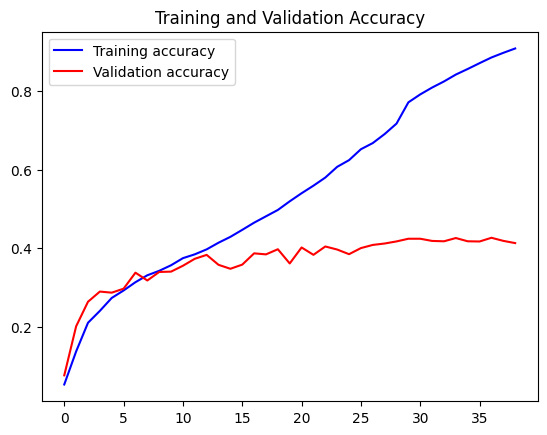

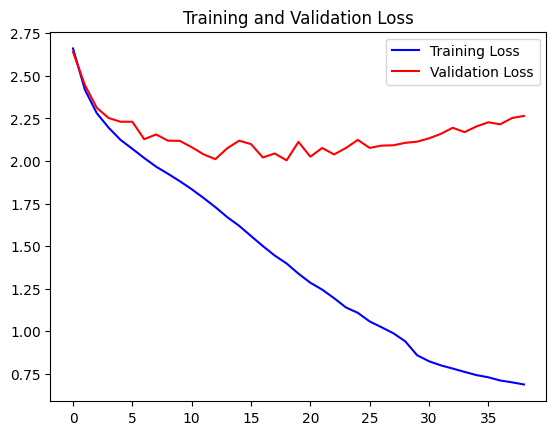

In [32]:
# Normal
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'b', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'b', label='Training Loss')
# plt.plot(epochs, val_loss, 'r', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# plt.show()

# AlexNet 
acc = history_alexNet.history['accuracy']
val_acc = history_alexNet.history['val_accuracy']
loss = history_alexNet.history['loss']
val_loss = history_alexNet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [33]:
alexNet.evaluate(test_ds)

191/191 [==============================] - 34s 177ms/step - loss: 1.9962 - accuracy: 0.4012


[1.9961668252944946, 0.4011628031730652]

Selected random image at index 10310
True class: Renaissance
1/1 [==============================] - 0s 19ms/step

Top 3 predictions for the sample image:
1. Baroque: 0.477
2. Renaissance: 0.301
3. Romanticism: 0.074


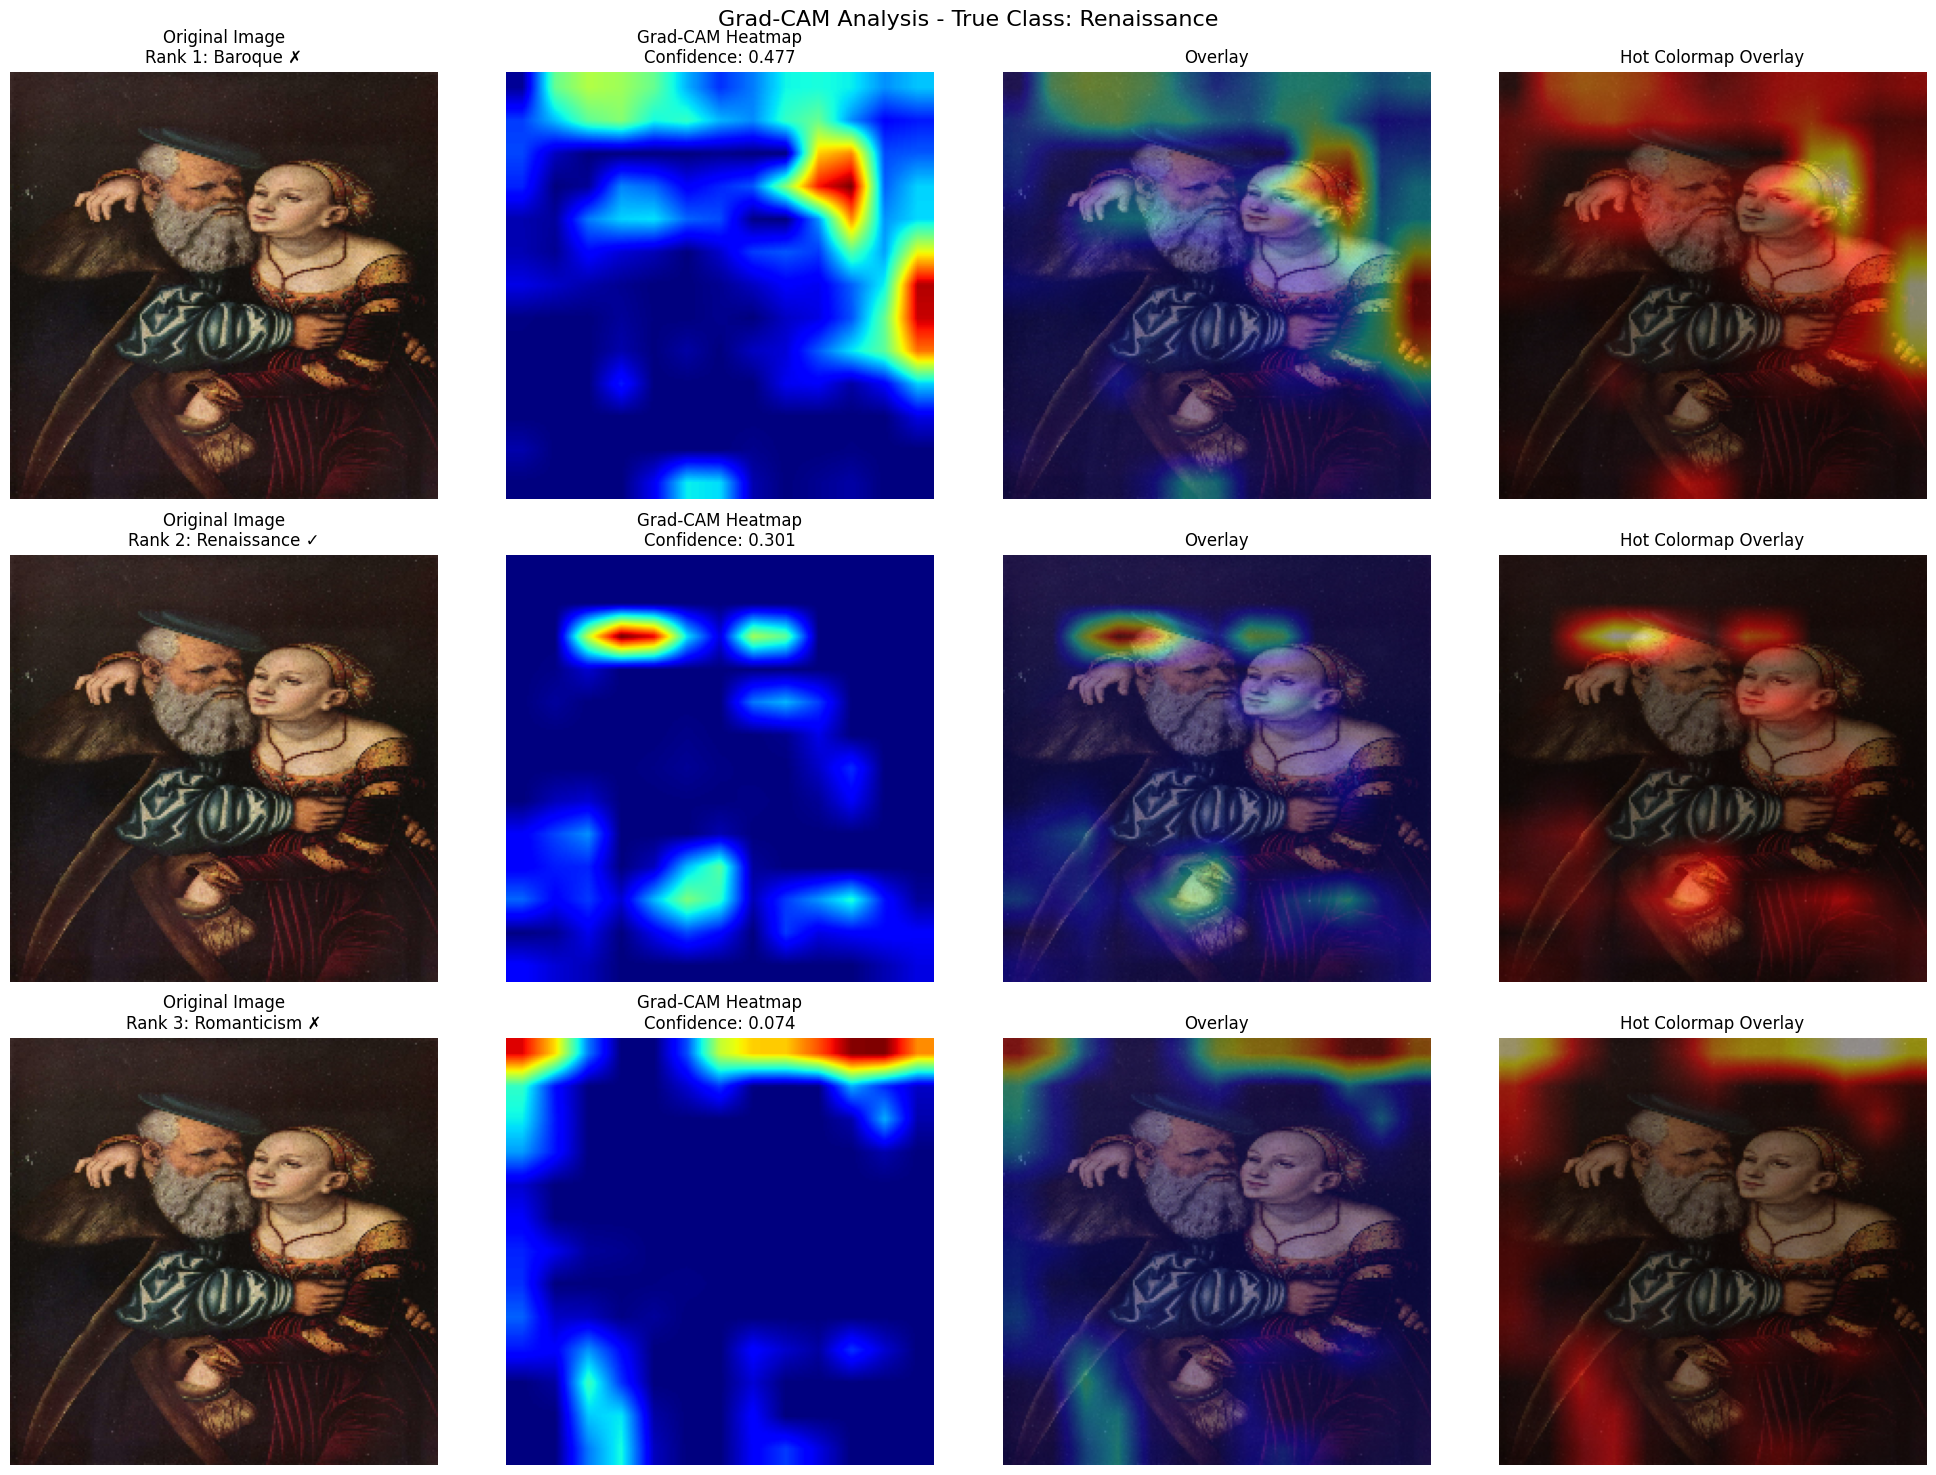

In [36]:
import numpy as np

# Select a random image from the test set
random_index = np.random.randint(0, len(X_test_paths))
sample_image_path = X_test_paths[random_index]
true_label = y_test_labels[random_index]

print(f"Selected random image at index {random_index}")
print(f"True class: {grouped_styles[true_label]}")

# Get the top 3 predicted classes for the sample image
sample_predictions = alexNet.predict(tf.expand_dims(tf.cast(tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(sample_image_path), channels=3), [224, 224]), tf.float32) / 255.0, axis=0))
top3_indices = np.argsort(sample_predictions[0])[-3:][::-1]  # Get top 3 in descending order
top3_probs = sample_predictions[0][top3_indices]

print(f"\nTop 3 predictions for the sample image:")
for i, (idx, prob) in enumerate(zip(top3_indices, top3_probs)):
    print(f"{i+1}. {grouped_styles[idx]}: {prob:.3f}")

# Define Grad-CAM function
def get_gradcam(model, img_array, layer_name, class_idx=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    
    # Extract the gradients of the top predicted class with regard to the output feature map
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Pool the gradients across the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    
    # Weight the feature map by the pooled gradients
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    # Resize heatmap to match input image size
    heatmap = tf.image.resize(tf.expand_dims(heatmap, -1), [224, 224])
    heatmap = tf.squeeze(heatmap)
    
    return heatmap.numpy()

# Visualize Grad-CAM for each of the top 3 classes
def visualize_gradcam_top3(model, image_path, top3_classes, top3_probs, true_class, layer_name='conv2d_4'):
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img_array = tf.cast(img, tf.float32) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)
    
    # Create visualization for top 3 classes
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    for i, (class_idx, prob) in enumerate(zip(top3_classes, top3_probs)):
        # Generate Grad-CAM heatmap for specific class
        heatmap = get_gradcam(model, img_array, layer_name, class_idx=class_idx)
        
        # Original image
        axes[i, 0].imshow(img_array[0])
        correct = "✓" if class_idx == true_class else "✗"
        axes[i, 0].set_title(f'Original Image\nRank {i+1}: {grouped_styles[class_idx]} {correct}')
        axes[i, 0].axis('off')
        
        # Heatmap
        axes[i, 1].imshow(heatmap, cmap='jet')
        axes[i, 1].set_title(f'Grad-CAM Heatmap\nConfidence: {prob:.3f}')
        axes[i, 1].axis('off')
        
        # Overlay
        axes[i, 2].imshow(img_array[0])
        axes[i, 2].imshow(heatmap, cmap='jet', alpha=0.4)
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
        
        # Heatmap with different colormap for better contrast
        axes[i, 3].imshow(img_array[0])
        axes[i, 3].imshow(heatmap, cmap='hot', alpha=0.5)
        axes[i, 3].set_title('Hot Colormap Overlay')
        axes[i, 3].axis('off')
    
    plt.suptitle(f'Grad-CAM Analysis - True Class: {grouped_styles[true_class]}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Use the correct layer name from AlexNet (last conv layer)
visualize_gradcam_top3(alexNet, sample_image_path, top3_indices, top3_probs, true_label, layer_name='conv2d_4')


In [35]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = alexNet.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = y_test_labels
print(classification_report(y_test_classes, y_pred_classes, target_names=styles))

191/191 [==============================] - 20s 106ms/step
                       precision    recall  f1-score   support

   Art_Nouveau_Modern       0.29      0.33      0.31       650
              Baroque       0.39      0.56      0.46       636
 Color_Field_Painting       0.56      0.58      0.57       243
               Cubism       0.24      0.42      0.31       384
        Expressionism       0.37      0.16      0.22      1439
              Fauvism       0.18      0.25      0.21       140
        Impressionism       0.68      0.46      0.55      3002
           Minimalism       0.43      0.57      0.49       200
Naive_Art_Primitivism       0.26      0.34      0.30       361
              Pop_Art       0.24      0.29      0.26       222
              Realism       0.42      0.32      0.36      1729
          Renaissance       0.43      0.57      0.49       985
               Rococo       0.34      0.61      0.44       314
          Romanticism       0.35      0.36      0.35      1

In [37]:
alexNet.save('model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(alexNet)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmp4a9gzli0\assets


INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmp4a9gzli0\assets
